<a href="https://colab.research.google.com/github/nikhilgunti/Annotation-Converters/blob/master/Stock_Pred_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
%cd '/content/drive/MyDrive/Case_Competition/news_sent'

/content/drive/MyDrive/Case_Competition/news_sent


In [41]:
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np # linear algebra
import random
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from pylab import mpl, plt
plt.style.use('seaborn')
mpl.rcParams['font.family'] = 'serif'
%matplotlib inline

from pandas import datetime
import math, time
import itertools
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
import xgboost as xgb
from sklearn.metrics import accuracy_score
import datetime
from operator import itemgetter
from sklearn.metrics import mean_squared_error
from math import sqrt
import torch
import torch.nn as nn
from torch.autograd import Variable

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  if sys.path[0] == '':


In [60]:
df = pd.read_excel('merged_data.xlsx', sheet_name='merged')
df = df.sort_values('Date')
df.head()

,closing_price,Date,Score,opening_price
0,81.03,2017-03-08,-0.142813,81.97
1,81.67,2017-03-09,-0.139117,82.29
2,81.61,2017-03-10,-0.137956,81.63
3,81.42,2017-03-11,-0.128134,NaN
4,80.99,2017-03-12,-0.136949,NaN


In [61]:
df = df.fillna(method='ffill')
#df['Date']..interpolate(method='polynomial')
df.head()

,closing_price,Date,Score,opening_price
0,81.03,2017-03-08,-0.142813,81.97
1,81.67,2017-03-09,-0.139117,82.29
2,81.61,2017-03-10,-0.137956,81.63
3,81.42,2017-03-11,-0.128134,81.63
4,80.99,2017-03-12,-0.136949,81.63


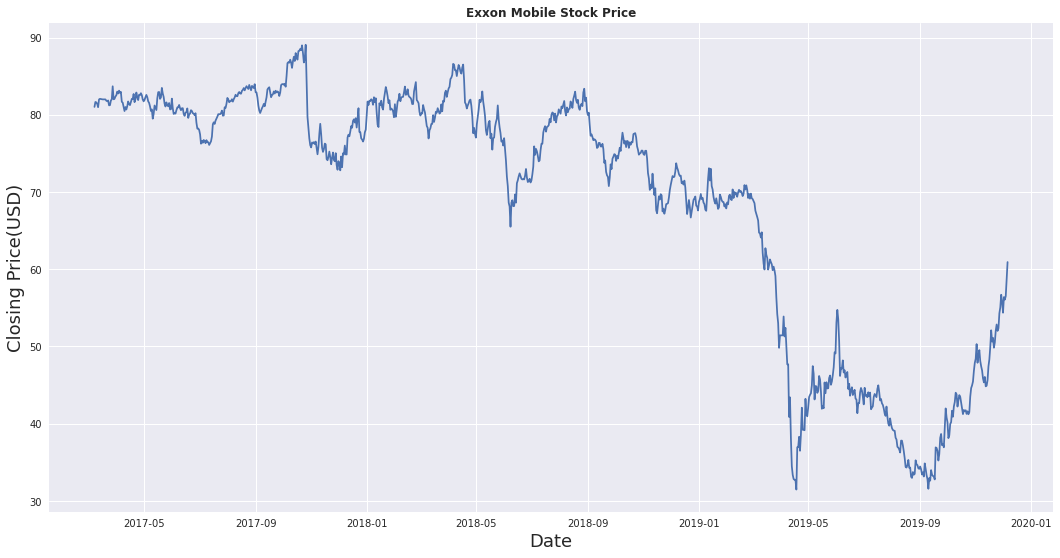

In [62]:
sns.set_style("darkgrid")
plt.figure(figsize=(18,9))
plt.plot(df['Date'], df['closing_price'])
plt.title("Exxon Mobile Stock Price", fontweight='bold')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Closing Price(USD)', fontsize=18)
plt.show()

In [167]:
data = df[['Date', 'Score', 'closing_price']]
train_data, test_data = data[0:int(len(data)*0.8)], data[int(len(data)*0.8):]

train_data = train_data.set_index('Date', drop= False)
test_data = test_data.set_index('Date', drop= False)

In [168]:
X_train, X_cv = train_data[0:int(len(train_data)*0.8)], train_data[int(len(train_data)*0.8):]

X_train = X_train.set_index('Date', drop= False)
X_cv = X_cv.set_index('Date', drop= False)

In [169]:
len(X_cv), len(test_data)

(160, 200)

In [170]:
def create_dataset(dataset, scoreset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		b = scoreset[i+look_back-1]
		dataX.append(np.append(a,b))
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

In [172]:
# Feature Scaling
sc = MinMaxScaler()
training_set_scaled = sc.fit_transform(X_train['closing_price'].values.reshape(-1, 1))
cv_set_scaled = sc.transform(X_cv['closing_price'].values.reshape(-1, 1))
test_set_scaled = sc.transform(test_data['closing_price'].values.reshape(-1, 1))

sc1 = MinMaxScaler()
training_score_scaled = sc1.fit_transform(X_train['Score'].values.reshape(-1, 1))
cv_score_scaled = sc1.transform(X_cv['Score'].values.reshape(-1, 1))
test_score_scaled = sc1.transform(test_data['Score'].values.reshape(-1, 1))

In [174]:
trainX, trainY = create_dataset(training_set_scaled, training_score_scaled, 60)
cvX, cvY = create_dataset(cv_set_scaled, cv_score_scaled, 60)
testX, testY = create_dataset(test_set_scaled, test_score_scaled, 60)

In [175]:
trainX.shape, cvX.shape, testX.shape

((579, 61), (99, 61), (139, 61))

In [176]:
#Reshaping all data.

trainX, trainY = np.array(trainX), np.array(trainY)
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))

cvX, cvY = np.array(cvX), np.array(cvY)
cvX = np.reshape(cvX, (cvX.shape[0], cvX.shape[1], 1))

testX, testY = np.array(testX), np.array(testY)
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

In [ ]:
import tensorflow as tf 
from tensorflow import keras
from keras.callbacks import TensorBoard

!rm -rf ./logs/
keras.backend.clear_session()
%load_ext tensorboard

model = Sequential()

# Adding the input layer
model.add(LSTM(units=128, activation='tanh', kernel_initializer=tf.keras.initializers.glorot_uniform(seed=26), input_shape = (trainX.shape[1], 1), unroll = True))

# Adding the output layer
model.add(Dense(1, name="output_layer"))

# Compiling the RNN
model.compile(optimizer = keras.optimizers.Adam(learning_rate=0.01), loss = tf.keras.metrics.mean_squared_error)

#Using Tensorboard
logdir = "logs"
tensorboard_callback = TensorBoard(log_dir=logdir, histogram_freq=5, write_graph=True)

# Fitting the RNN to the Training set
model.fit(trainX, trainY, epochs = 30, batch_size = 64,  validation_data = (cvX, cvY), callbacks = [tensorboard_callback])

In [193]:
#Predicting on test data
predicted_stock_price = model.predict(testX)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

In [194]:
#Changing datatype of date column from string to datetime

train_data['Date'] = pd.to_datetime(train_data['Date'])
test_data['Date'] = pd.to_datetime(test_data['Date'])

train_data['Date'] = train_data['Date'].dt.date
test_data['Date'] = test_data['Date'].dt.date

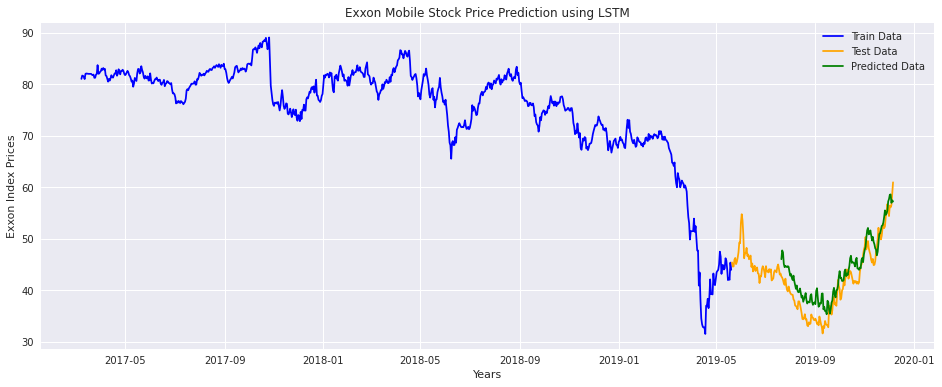

RMSE_LSTM = 3.2341624339956017


In [195]:
# Visualising the results
plt.figure(figsize=(16, 6))
plt.plot(train_data['Date'], train_data['closing_price'], color = 'blue', label = 'Train Data')
plt.plot(test_data['Date'], test_data['closing_price'].values, color = 'orange', label = 'Test Data')
plt.plot(test_data.iloc[61:]['Date'], predicted_stock_price, color = 'green', label = 'Predicted Data')
plt.title('Exxon Mobile Stock Price Prediction using LSTM')
plt.xlabel('Years')
plt.ylabel('Exxon Index Prices')
plt.legend()
plt.show()
from math import sqrt

RMSE_LSTM = sqrt(mean_squared_error(test_data.iloc[61:]['closing_price'].values, predicted_stock_price))

print(f"RMSE_LSTM = {RMSE_LSTM}")

#Impact of News and other biases on Stock -- final merged dataset

In [324]:
df_2 = pd.read_csv('/content/drive/MyDrive/Case_Competition/news_sent/final_merged.csv')
df_2.head()

,Ticker_gse,Stock Name_gse,Value_gse,Date Value_gse,yearQuar_gse,DOW JONES COMPOSITE AVERAGE,DOW JONES INDUSTRIAL AVERAGE,DOW JONES TRANSPORTATION AVERAGE,DOW JONES UTILITY AVERAGE,S&P 500,GROCERY AND PHARMACY PERCENT CHANGE FROM BASELINE,PARKS PERCENT CHANGE FROM BASELINE,RESIDENTIAL PERCENT CHANGE FROM BASELINE,RETAIL AND RECREATION PERECENT CHANGE FROM BASELINE,TRANSIT STATIONS PERCENT CHANGE FROM BASELINE,WORKPLACES PERCENT CHANGE FROM BASELINE,Value_jodi,month,year,COAL PRODUCTION TOTAL U.S._shortene,U.S. CRUDE OIL PRODUCTION_shortene,U.S. TOTAL ENERGY CONSUMPTION_shortene,LONG-TERM INTEREST RATES_interates,SHORT-TERM INTEREST RATES_interates,SINGAPORE JET KERO VS SINGAPORE GASOIL SWAP_enerfutup,BRENT CRUDE OIL (DOLLARS PER BARREL),WTI CRUDE OIL (DOLLARS PER BARREL),Polarity
0,VLO,VALERO ENERGY CORPORATION,79.03,3/5/2021,2021Q1,10435.92,31496.3,13627.98,814.03,3841.94,-5.058824,1.060465,6.37605,-15.416667,-24.074074,-17.755716,NaN,3,2021,56.25,13.56,8.49,NaN,0.11,NaN,69.95,66.08,-0.144684
1,XOM,EXXON MOBIL CORPORATION,60.93,3/5/2021,2021Q1,10435.92,31496.3,13627.98,814.03,3841.94,-5.058824,1.060465,6.37605,-15.416667,-24.074074,-17.755716,NaN,3,2021,56.25,13.56,8.49,NaN,0.11,NaN,69.95,66.08,-0.144684
2,MPC,MARATHON PETROLEUM CORPORATION,57.32,3/5/2021,2021Q1,10435.92,31496.3,13627.98,814.03,3841.94,-5.058824,1.060465,6.37605,-15.416667,-24.074074,-17.755716,NaN,3,2021,56.25,13.56,8.49,NaN,0.11,NaN,69.95,66.08,-0.144684
3,OXY,OCCIDENTAL PETROLEUM CORPORATION,31.23,3/5/2021,2021Q1,10435.92,31496.3,13627.98,814.03,3841.94,-5.058824,1.060465,6.37605,-15.416667,-24.074074,-17.755716,NaN,3,2021,56.25,13.56,8.49,NaN,0.11,NaN,69.95,66.08,-0.144684
4,CVX,CHEVRON CORPORATION,109.00,3/5/2021,2021Q1,10435.92,31496.3,13627.98,814.03,3841.94,-5.058824,1.060465,6.37605,-15.416667,-24.074074,-17.755716,NaN,3,2021,56.25,13.56,8.49,NaN,0.11,NaN,69.95,66.08,-0.144684


In [336]:
df_2.shape

(10502, 28)

In [325]:
(df_2.isna().sum()/len(df_2))*100

Ticker_gse                                                0.000000
Stock Name_gse                                            0.000000
Value_gse                                                 0.000000
Date Value_gse                                            0.000000
yearQuar_gse                                              0.000000
DOW JONES COMPOSITE AVERAGE                               0.856980
DOW JONES INDUSTRIAL AVERAGE                              0.856980
DOW JONES TRANSPORTATION AVERAGE                          0.856980
DOW JONES UTILITY AVERAGE                                 0.856980
S&P 500                                                   0.856980
GROCERY AND PHARMACY PERCENT CHANGE FROM BASELINE        75.033327
PARKS PERCENT CHANGE FROM BASELINE                       75.033327
RESIDENTIAL PERCENT CHANGE FROM BASELINE                 75.033327
RETAIL AND RECREATION PERECENT CHANGE FROM BASELINE      75.033327
TRANSIT STATIONS PERCENT CHANGE FROM BASELINE            75.03

In [9]:
df_copy = df_2.copy()
columns = ['GROCERY AND PHARMACY PERCENT CHANGE FROM BASELINE','PARKS PERCENT CHANGE FROM BASELINE', 'RESIDENTIAL PERCENT CHANGE FROM BASELINE',
                        'RETAIL AND RECREATION PERECENT CHANGE FROM BASELINE', 'TRANSIT STATIONS PERCENT CHANGE FROM BASELINE',
                        'WORKPLACES PERCENT CHANGE FROM BASELINE', 'SINGAPORE JET KERO VS SINGAPORE GASOIL SWAP_enerfutup']
df_copy = df_copy.drop(columns=columns, axis=1)
df_copy.head()

,Ticker_gse,Stock Name_gse,Value_gse,Date Value_gse,yearQuar_gse,DOW JONES COMPOSITE AVERAGE,DOW JONES INDUSTRIAL AVERAGE,DOW JONES TRANSPORTATION AVERAGE,DOW JONES UTILITY AVERAGE,S&P 500,Value_jodi,month,year,COAL PRODUCTION TOTAL U.S._shortene,U.S. CRUDE OIL PRODUCTION_shortene,U.S. TOTAL ENERGY CONSUMPTION_shortene,LONG-TERM INTEREST RATES_interates,SHORT-TERM INTEREST RATES_interates,BRENT CRUDE OIL (DOLLARS PER BARREL),WTI CRUDE OIL (DOLLARS PER BARREL),Polarity
0,VLO,VALERO ENERGY CORPORATION,79.03,3/5/2021,2021Q1,10435.92,31496.3,13627.98,814.03,3841.94,NaN,3,2021,56.25,13.56,8.49,NaN,0.11,69.95,66.08,-0.144684
1,XOM,EXXON MOBIL CORPORATION,60.93,3/5/2021,2021Q1,10435.92,31496.3,13627.98,814.03,3841.94,NaN,3,2021,56.25,13.56,8.49,NaN,0.11,69.95,66.08,-0.144684
2,MPC,MARATHON PETROLEUM CORPORATION,57.32,3/5/2021,2021Q1,10435.92,31496.3,13627.98,814.03,3841.94,NaN,3,2021,56.25,13.56,8.49,NaN,0.11,69.95,66.08,-0.144684
3,OXY,OCCIDENTAL PETROLEUM CORPORATION,31.23,3/5/2021,2021Q1,10435.92,31496.3,13627.98,814.03,3841.94,NaN,3,2021,56.25,13.56,8.49,NaN,0.11,69.95,66.08,-0.144684
4,CVX,CHEVRON CORPORATION,109.00,3/5/2021,2021Q1,10435.92,31496.3,13627.98,814.03,3841.94,NaN,3,2021,56.25,13.56,8.49,NaN,0.11,69.95,66.08,-0.144684


In [10]:
miss_col = ['DOW JONES COMPOSITE AVERAGE', 'DOW JONES INDUSTRIAL AVERAGE', 'DOW JONES TRANSPORTATION AVERAGE',
       'DOW JONES UTILITY AVERAGE', 'S&P 500', 'Value_jodi', 'LONG-TERM INTEREST RATES_interates',
       'SHORT-TERM INTEREST RATES_interates', 'BRENT CRUDE OIL (DOLLARS PER BARREL)', 'WTI CRUDE OIL (DOLLARS PER BARREL)']

df_copy[miss_col]= df_copy[miss_col].fillna(value=df_copy[miss_col].mean())
(df_copy.isna().sum()/len(df_2))*100

Ticker_gse                                0.0
Stock Name_gse                            0.0
Value_gse                                 0.0
Date Value_gse                            0.0
yearQuar_gse                              0.0
DOW JONES COMPOSITE AVERAGE               0.0
DOW JONES INDUSTRIAL AVERAGE              0.0
DOW JONES TRANSPORTATION AVERAGE          0.0
DOW JONES UTILITY AVERAGE                 0.0
S&P 500                                   0.0
Value_jodi                                0.0
month                                     0.0
year                                      0.0
COAL PRODUCTION TOTAL U.S._shortene       0.0
U.S. CRUDE OIL PRODUCTION_shortene        0.0
U.S. TOTAL ENERGY CONSUMPTION_shortene    0.0
LONG-TERM INTEREST RATES_interates        0.0
SHORT-TERM INTEREST RATES_interates       0.0
BRENT CRUDE OIL (DOLLARS PER BARREL)      0.0
WTI CRUDE OIL (DOLLARS PER BARREL)        0.0
Polarity                                  0.0
dtype: float64

In [ ]:
df_copy['Date Value_gse']= pd.to_datetime(df_copy['Date Value_gse'])
df_copy.info()

In [337]:
df_copy.shape

(10502, 21)

In [339]:
df_stock = df_copy[df_copy['Ticker_gse']=='PSX']
df_stock.head()

,Ticker_gse,Stock Name_gse,Value_gse,Date Value_gse,yearQuar_gse,DOW JONES COMPOSITE AVERAGE,DOW JONES INDUSTRIAL AVERAGE,DOW JONES TRANSPORTATION AVERAGE,DOW JONES UTILITY AVERAGE,S&P 500,Value_jodi,month,year,COAL PRODUCTION TOTAL U.S._shortene,U.S. CRUDE OIL PRODUCTION_shortene,U.S. TOTAL ENERGY CONSUMPTION_shortene,LONG-TERM INTEREST RATES_interates,SHORT-TERM INTEREST RATES_interates,BRENT CRUDE OIL (DOLLARS PER BARREL),WTI CRUDE OIL (DOLLARS PER BARREL),Polarity
5,PSX,PHILLIPS 66,87.35,2021-03-05,2021Q1,10435.92,31496.30,13627.98,814.03,3841.94,20004.305681,3,2021,56.25,13.56,8.49,2.02278,0.11,69.95,66.08,-0.144684
15,PSX,PHILLIPS 66,84.41,2021-03-04,2021Q1,10213.87,30924.14,13219.66,800.17,3768.47,20004.305681,3,2021,56.25,13.56,8.49,2.02278,0.11,67.32,63.81,-0.155546
25,PSX,PHILLIPS 66,83.84,2021-03-03,2021Q1,10348.77,31270.09,13548.44,798.59,3819.72,20004.305681,3,2021,56.25,13.56,8.49,2.02278,0.11,64.70,61.33,-0.150189
35,PSX,PHILLIPS 66,82.27,2021-03-02,2021Q1,10390.16,31391.52,13571.99,806.08,3870.29,20004.305681,3,2021,56.25,13.56,8.49,2.02278,0.11,63.17,59.70,-0.131861
45,PSX,PHILLIPS 66,84.70,2021-03-01,2021Q1,10435.40,31535.51,13618.09,810.38,3901.82,20004.305681,3,2021,56.25,13.56,8.49,2.02278,0.11,64.56,60.54,-0.072019


In [340]:
df_stock.shape

(1048, 21)

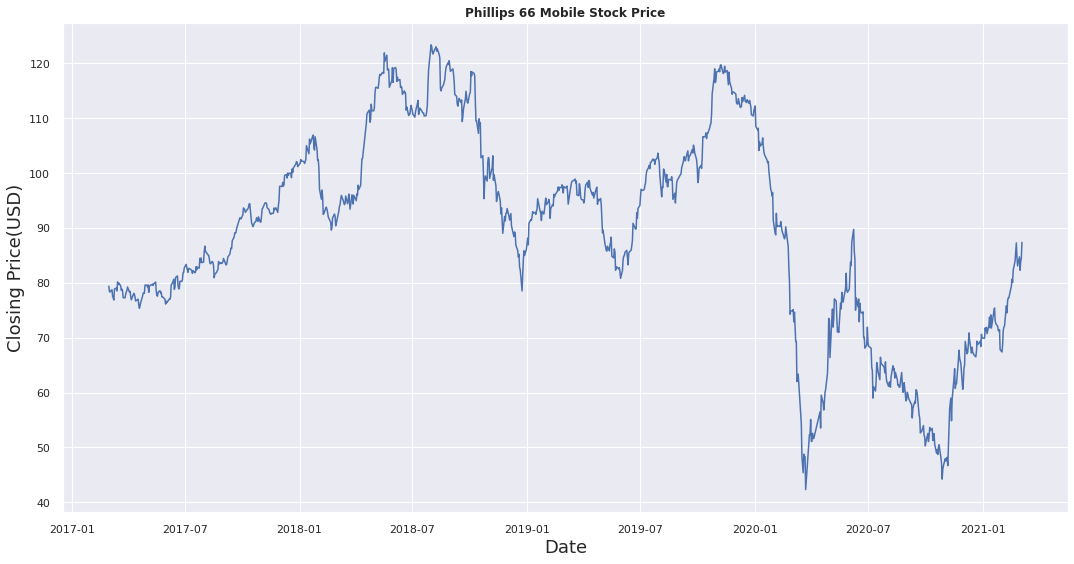

In [328]:
sns.set_style("darkgrid")
plt.figure(figsize=(18,9))
plt.plot(df_stock['Date Value_gse'], df_stock['Value_gse'])
plt.title("Phillips 66 Mobile Stock Price", fontweight='bold')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Closing Price(USD)', fontsize=18)
plt.show()

Trend: This is a non-stationary time series. We need to convert it to stationary to forecast accurately. Let's also check for the seasonality.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

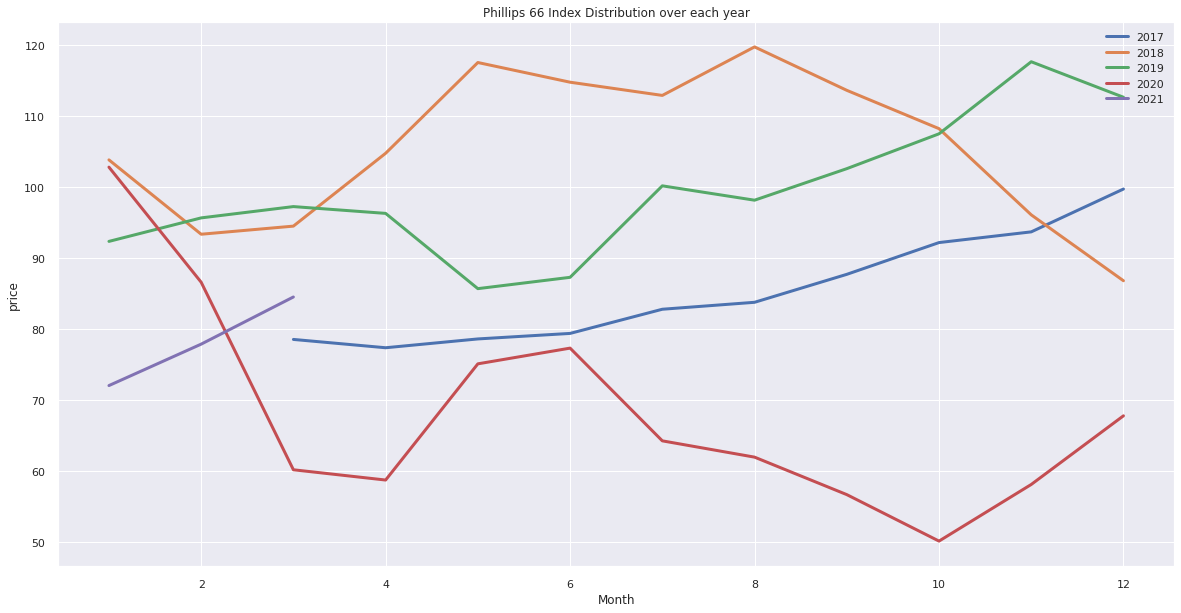

In [330]:
season = df_stock
season['Date'] = df_stock['Date Value_gse']
season['Year'] = df_stock['Date Value_gse'].dt.year
season['Month'] = df_stock['Date Value_gse'].dt.month
spivot = pd.pivot_table(season, index='Month', columns = 'Year', values = 'Value_gse')
spivot.plot(figsize=(20,10), linewidth=3)
plt.legend(loc = 'upper right')
plt.ylabel('price')
plt.title('Phillips 66 Index Distribution over each year')
plt.show()

Seasonality: The timeseries does not have seasonal variation.

Now let's check stationarity of time series. We can check stationarity using the following methods:

Plotting Rolling Statistics: We have a window lets say window size is 6 and then we find rolling mean and variance to check stationary.
Dickey-Fuller Test: The test results comprise of a Test Statistic and some Critical Values for difference confidence levels. If the test statistic is less than the critical value, we can say that time series is stationary. Here we state Null Hypothesis that our timeseries is non-stationary and the alternate hypothesis that the timeseries is stationary.
For timeseries to be stationary we should get a p-value of less than 5% to reject the null hypothesis.

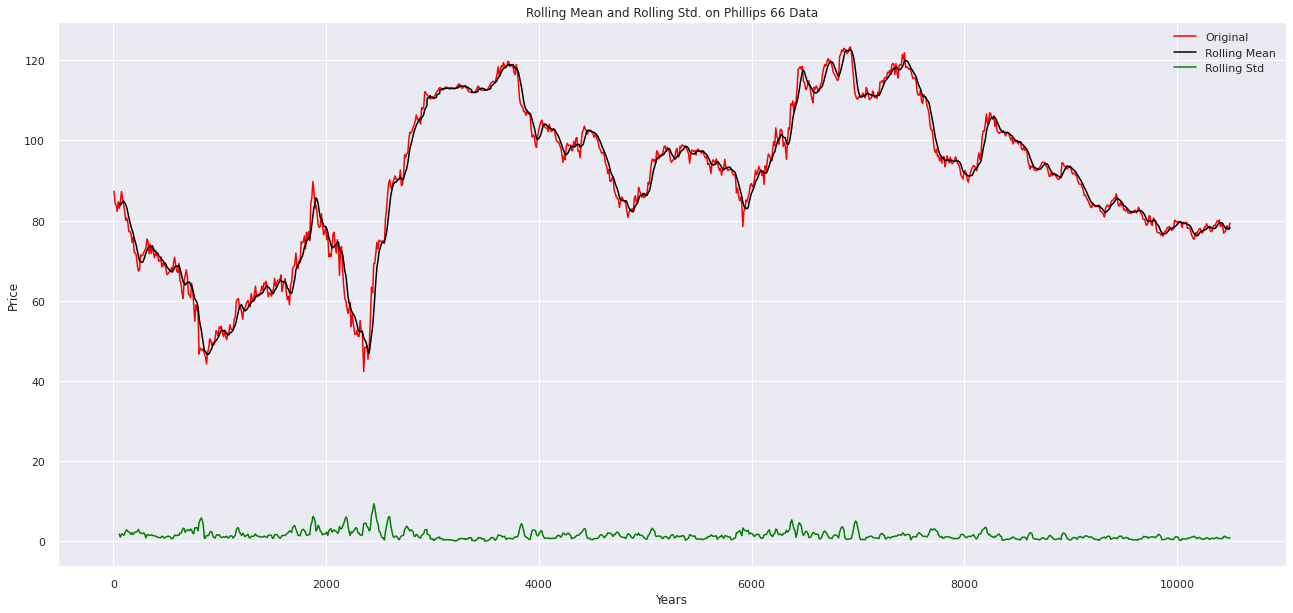

Test statistic:  -2.3348864982138218
p-value:  0.1609630608995805
Critical Values: {'1%': -3.436720930946538, '5%': -2.8643528789984187, '10%': -2.56826769663245}


In [331]:
ts = df_stock['Value_gse']
date = df_stock['Date Value_gse']

# adfuller library 
from statsmodels.tsa.stattools import adfuller

# check_adfuller
def check_adfuller(ts):

    # Dickey-Fuller test
    result = adfuller(ts, autolag='AIC')
    print('Test statistic: ' , result[0])
    print('p-value: '  ,result[1])
    print('Critical Values:' ,result[4])

# check_mean_std
def check_mean_std(ts):
    
    #Rolling statistics
    rolmean = ts.rolling(6).mean()
    rolstd = ts.rolling(6).std()
    plt.figure(figsize=(22,10))   
    orig = plt.plot(ts, color='red',label='Original')
    mean = plt.plot(rolmean, color='black', label='Rolling Mean')
    std = plt.plot(rolstd, color='green', label = 'Rolling Std')
    plt.xlabel("Years")
    plt.ylabel("Price")
    plt.title('Rolling Mean and Rolling Std. on Phillips 66 Data')
    plt.legend()
    plt.show()
    
# check stationary: mean, variance(std) and adfuller test
check_mean_std(ts)
check_adfuller(ts)

Our first criteria for stationary is constant mean. So we fail because mean is not constant as you can see from plot (black line) above.

Second one is constant variance. It looks like constant. (Green Graph above)

Third one is that if the test statistic is less than the critical value, we can say that time series is stationary.

Lets look: Test statistic:  -2.33 and Critical Values: {'1%': -3.436720930946538, '5%': -2.8643528789984187, '10%': -2.56826769663245}. Test statistic is bigger than the critical values. So, no stationary.

As a result, we are sure that our time series is not stationary. Lets make time series stationary at the next part.

We can do so with the help of two methods:

1.Moving Average Method
2.Differencing Method

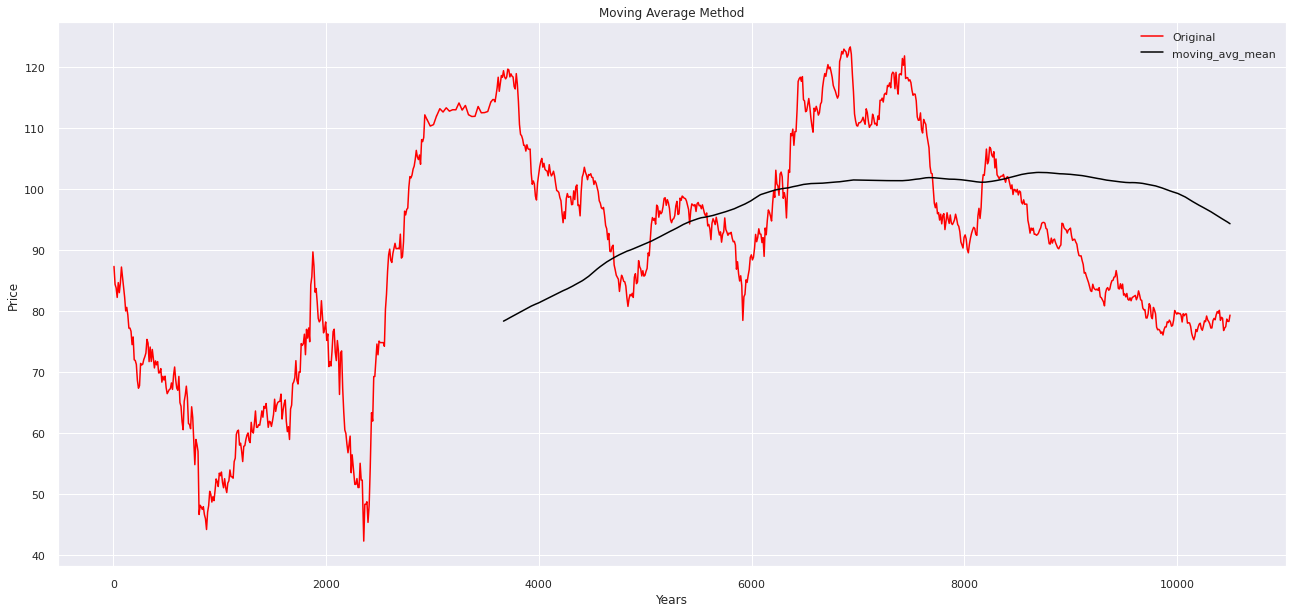

In [332]:
window_size = 365
moving_avg = ts.rolling(window_size).mean()
plt.figure(figsize=(22,10))
plt.plot(ts, color = "red",label = "Original")
plt.plot(moving_avg, color='black', label = "moving_avg_mean")
plt.title("Moving Average Method")
plt.xlabel("Years")
plt.ylabel("Price")
plt.legend()
plt.show()

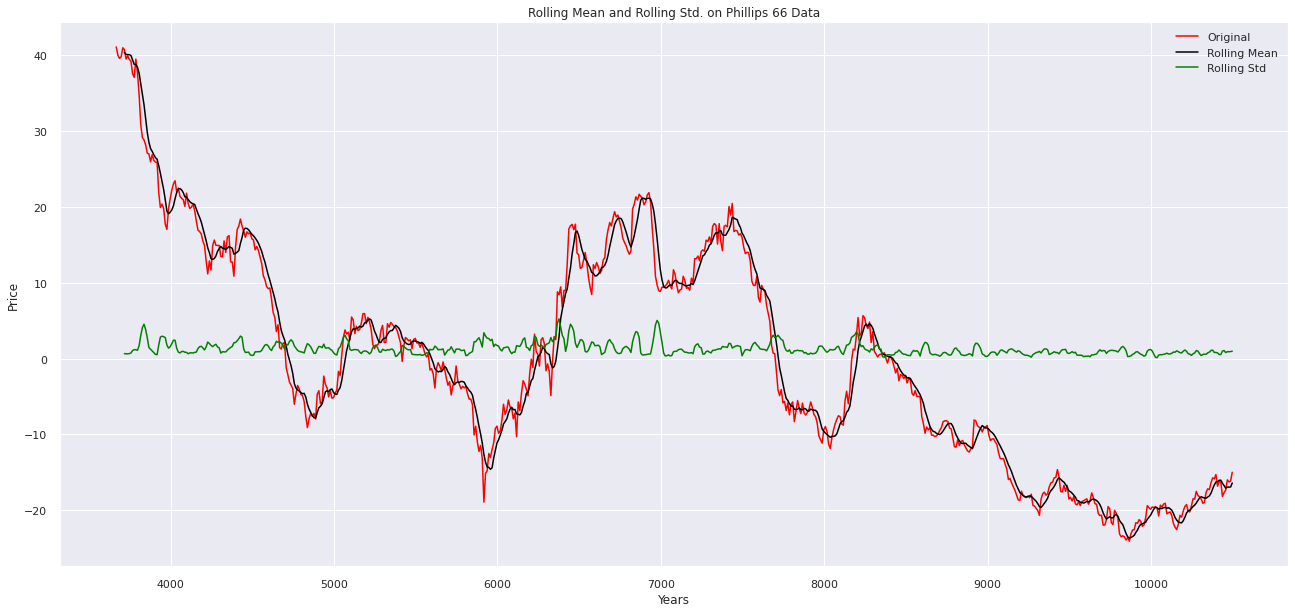

Test statistic:  -2.6677996972135563
p-value:  0.07977798475778042
Critical Values: {'1%': -3.439960610754265, '5%': -2.8657809735786244, '10%': -2.5690284373908066}


In [333]:
ts_moving_avg_diff = ts - moving_avg
ts_moving_avg_diff.dropna(inplace=True) # first 3 is nan value due to window size

# check stationary: mean, variance(std)and adfuller test
check_mean_std(ts_moving_avg_diff)
check_adfuller(ts_moving_avg_diff)

Mean is constant over time now. There is no trend visible, p-value is also less than 5%. But test statistic is not less than Critical Value. Variance is not constant.

Our time series is still not stationary. Let's try the differencing method.

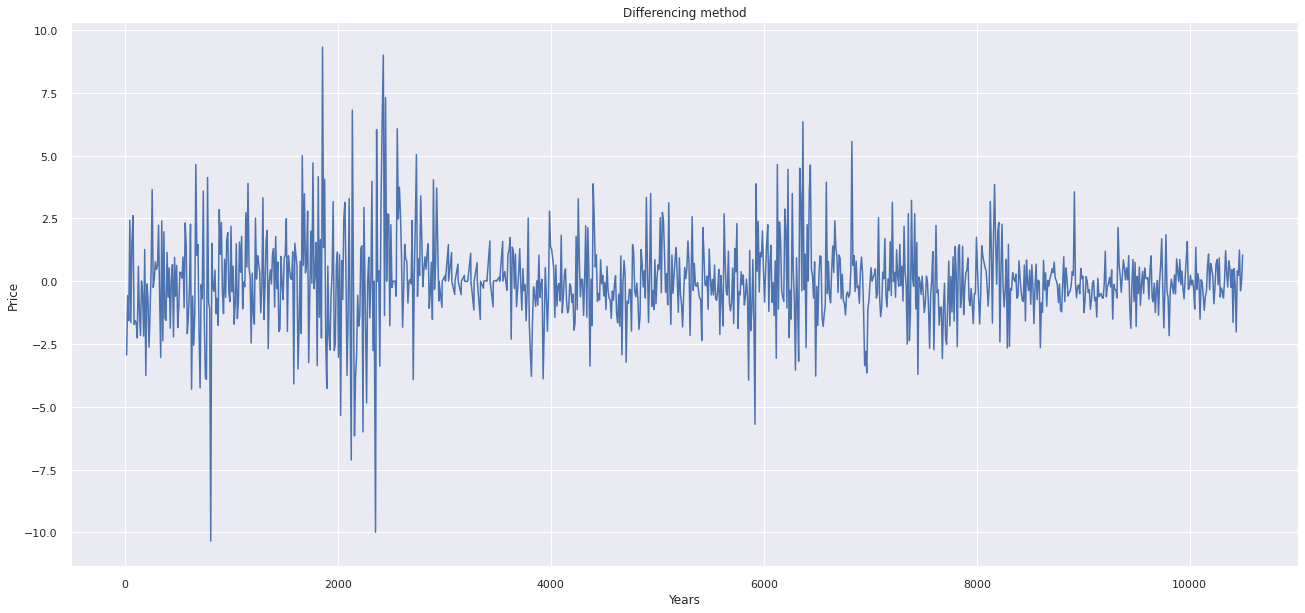

In [334]:
# differencing method

#shifting by 1 period
ts_diff = ts - ts.shift(1)
plt.figure(figsize=(22,10))
plt.plot(ts_diff)
plt.title("Differencing method") 
plt.xlabel("Years")
plt.ylabel("Price")
plt.show()

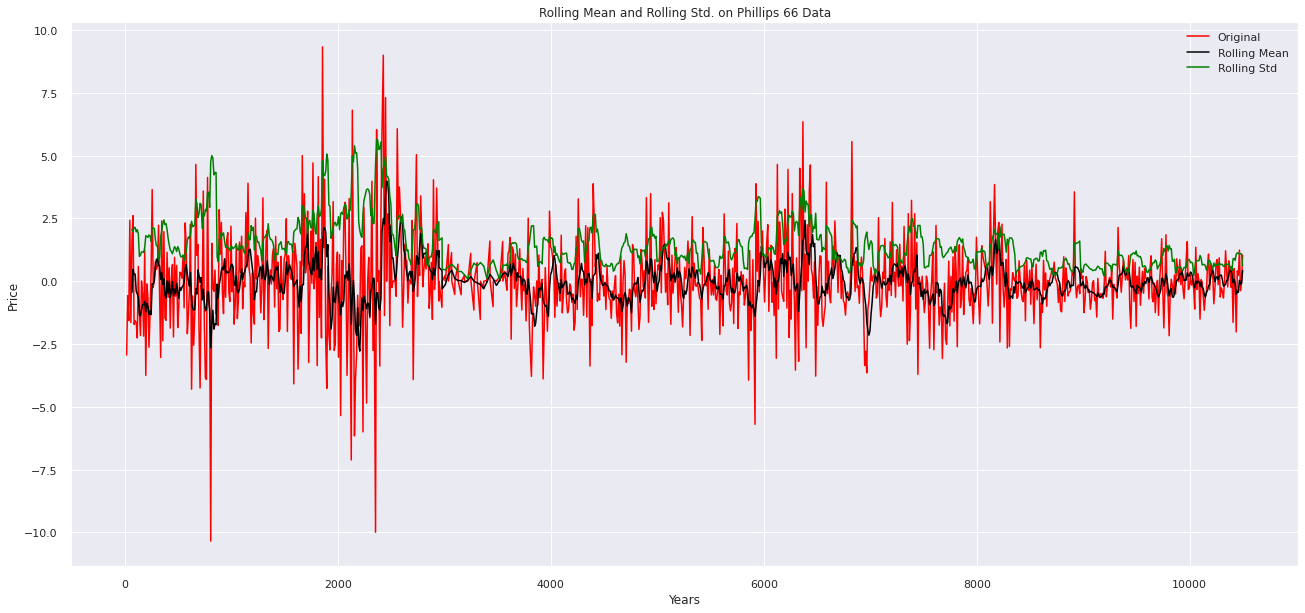

Test statistic:  -6.677666014925394
p-value:  4.4229965634830025e-09
Critical Values: {'1%': -3.4367085412302205, '5%': -2.8643474145110512, '10%': -2.568264786168072}


In [335]:
ts_diff.dropna(inplace=True) # due to shifting there is nan values
# check stationary: mean, variance(std)and adfuller test
check_mean_std(ts_diff)
check_adfuller(ts_diff)

Mean is constant over time. There is no trend visible, p-value is also less than 5%. Test Statistic is also less than Critical Value. But variance is not constant.

Great! Our time series is almost stationary now. We can use this time series for forecasting and can produce considerable results.

In [ ]:
# Create 7 and 21 days Moving Average
df_stock['ma7'] = df_stock[['Value_gse']].rolling(window=7).mean()
df_stock['ma21'] = df_stock[['Value_gse']].rolling(window=21).mean()
    
# Create MACD
df_stock['26ema'] = pd.DataFrame.ewm(df_stock[['Value_gse']], span=26).mean()
df_stock['12ema'] = pd.DataFrame.ewm(df_stock[['Value_gse']], span=12).mean()
df_stock['MACD'] = (df_stock['12ema']-df_stock['26ema'])

# Create Bollinger Bands
df_stock['20sd'] = df_stock[['Value_gse']].rolling(window=24).std()
df_stock['upper_band'] = df_stock['ma21'] + (df_stock['20sd']*2)
df_stock['lower_band'] = df_stock['ma21'] - (df_stock['20sd']*2)
    
# Create Exponential moving average
df_stock['ema'] = df_stock[['Value_gse']].ewm(com=0.5).mean()
    
# Create Momentum
df_stock['momentum'] = df_stock[['Value_gse']]-1

In [23]:
def plot_technical_indicators(dataset, last_days):
    plt.figure(figsize=(16, 10), dpi=100)
    shape_0 = dataset.shape[0]
    xmacd_ = shape_0-last_days
    
    dataset = dataset.iloc[-last_days:, :]
    x_ = range(3, dataset.shape[0])
    x_ =list(dataset.index)
    
    # Plot first subplot
    plt.subplot(2, 1, 1)
    plt.plot(dataset['ma7'],label='MA 7', color='g',linestyle='--')
    plt.plot(dataset['Value_gse'],label='Closing Price', color='b')
    plt.plot(dataset['ma21'],label='MA 21', color='r',linestyle='--')
    plt.plot(dataset['upper_band'],label='Upper Band', color='c')
    plt.plot(dataset['lower_band'],label='Lower Band', color='c')
    plt.fill_between(x_, dataset['lower_band'], dataset['upper_band'], alpha=0.35)
    plt.title('Technical indicators for Phillips 66 - last {} days.'.format(last_days))
    plt.ylabel('USD')
    plt.legend()

    # Plot second subplot
    plt.subplot(2, 1, 2)
    plt.title('MACD')
    plt.plot(dataset['MACD'],label='MACD', linestyle='-.')
    plt.hlines(15, xmacd_, shape_0, colors='g', linestyles='--')
    plt.hlines(-15, xmacd_, shape_0, colors='g', linestyles='--')
    plt.plot(dataset['momentum'],label='Momentum', color='b',linestyle='-')

    plt.legend()
    plt.show()

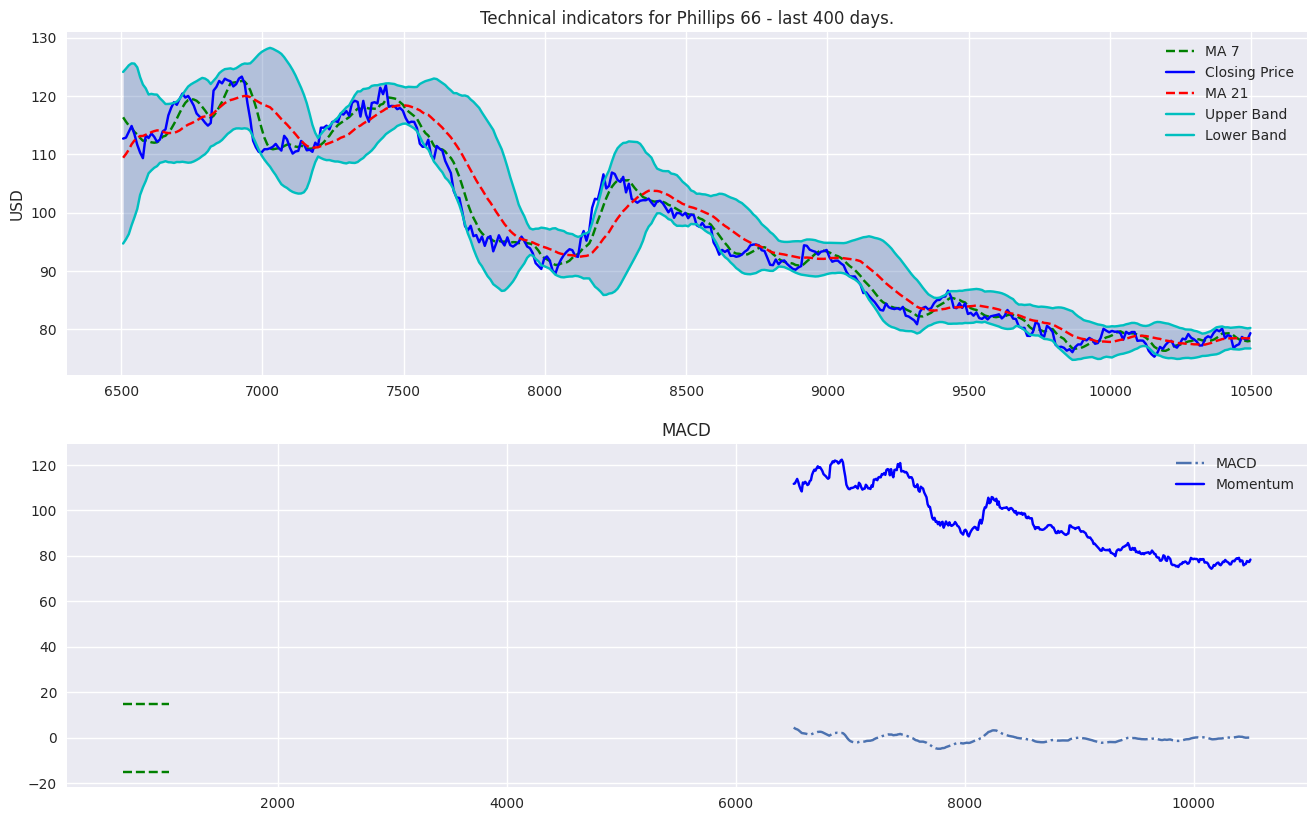

In [24]:
plot_technical_indicators(df_stock, 400)

#ARIMA model -- Stock closing price data

In [32]:
from statsmodels.tsa.arima_model import ARIMA
from pandas import DataFrame
from pandas import datetime

series = df_stock['Value_gse']
model = ARIMA(series, order=(5, 1, 0))
model_fit = model.fit(disp=0)
print(model_fit.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:            D.Value_gse   No. Observations:                 1047
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -2040.086
Method:                       css-mle   S.D. of innovations              1.698
Date:                Sun, 21 Mar 2021   AIC                           4094.171
Time:                        19:44:04   BIC                           4128.847
Sample:                             1   HQIC                          4107.321
                                                                              
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -0.0078      0.060     -0.130      0.897      -0.126       0.110
ar.L1.D.Value_gse    -0.0523      0.031     -1.692      0.091      -0.113       0.008
ar.L2.D.Value_gse     0.

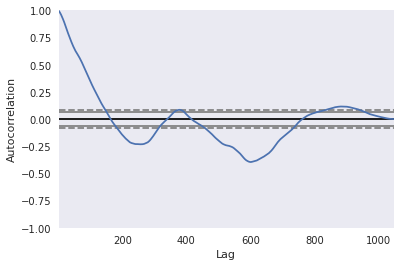

<Figure size 800x560 with 0 Axes>

In [34]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(series)
plt.figure(figsize=(10, 7), dpi=80)
plt.show() 

In [35]:
from pandas import read_csv
from pandas import datetime
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

X = series.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  


In [36]:
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)

Test MSE: 1.235


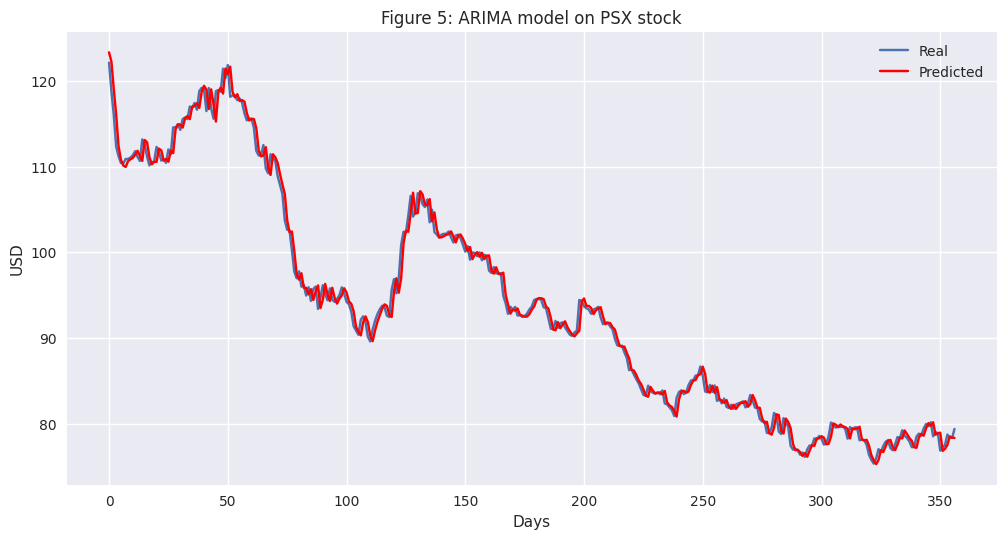

In [37]:
# Plot the predicted (from ARIMA) and real prices

plt.figure(figsize=(12, 6), dpi=100)
plt.plot(test, label='Real')
plt.plot(predictions, color='red', label='Predicted')
plt.xlabel('Days')
plt.ylabel('USD')
plt.title('Figure 5: ARIMA model on PSX stock')
plt.legend()
plt.show()

In [43]:
def get_feature_importance_data(data_income):
    data = data_income.copy()
    y = data['Value_gse']
    X = data.iloc[:, 5:]
    
    train_samples = int(X.shape[0] * 0.7)
 
    X_train = X.iloc[:train_samples]
    X_test = X.iloc[train_samples:]

    y_train = y.iloc[:train_samples]
    y_test = y.iloc[train_samples:]
    
    return (X_train, y_train), (X_test, y_test)

In [44]:
# Get training and test data
(X_train_FI, y_train_FI), (X_test_FI, y_test_FI) = get_feature_importance_data(df_stock)

In [45]:
regressor = xgb.XGBRegressor(gamma=0.0,n_estimators=150,base_score=0.7,colsample_bytree=1,learning_rate=0.05)
xgbModel = regressor.fit(X_train_FI,y_train_FI, \
                         eval_set = [(X_train_FI, y_train_FI), (X_test_FI, y_test_FI)], \
                         verbose=False)
eval_result = regressor.evals_result()
training_rounds = range(len(eval_result['validation_0']['rmse']))

[19:56:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


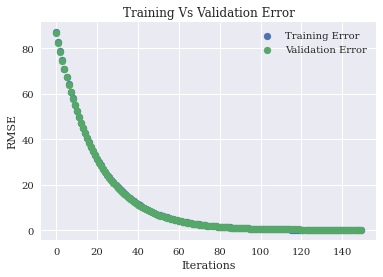

In [46]:
plt.scatter(x=training_rounds,y=eval_result['validation_0']['rmse'],label='Training Error')
plt.scatter(x=training_rounds,y=eval_result['validation_1']['rmse'],label='Validation Error')
plt.xlabel('Iterations')
plt.ylabel('RMSE')
plt.title('Training Vs Validation Error')
plt.legend()
plt.show()

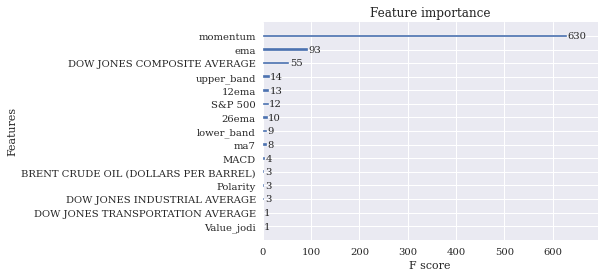

In [52]:
xgb.plot_importance(xgbModel)
plt.rcParams['figure.figsize'] = [5, 5]
plt.show()

In [57]:
np.mean(eval_result['validation_0']['rmse'])

11.747923980000001

In [ ]:
price = df_stock[['Date Value_gse', 'Value_gse', 'Polarity', 'momentum', 'ema', 'DOW JONES COMPOSITE AVERAGE', 'upper_band', 
                  '12ema', 'S&P 500', '26ema', 'lower_band', 'ma7', 'MACD',  'BRENT CRUDE OIL (DOLLARS PER BARREL)']]
price.head()

In [341]:
price.shape

(1048, 14)

#LSTM Model with just Stock closing Price and News Polarity Score

In [ ]:
price = price.sort_values(by=['Date Value_gse'])
price

In [223]:
train_data, test_data = price[0:int(len(price)*0.8)], price[int(len(price)*0.8):]

train_data = train_data.set_index('Date Value_gse', drop= False)
test_data = test_data.set_index('Date Value_gse', drop= False)

In [224]:
X_train, X_cv = train_data[0:int(len(train_data)*0.8)], train_data[int(len(train_data)*0.8):]

X_train = X_train.set_index('Date Value_gse', drop= False)
X_cv = X_cv.set_index('Date Value_gse', drop= False)

In [225]:
def create_dataset(dataset, scoreset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		b = scoreset[i+look_back-1]
		dataX.append(np.append(a,b))
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

In [226]:
sc = MinMaxScaler()
training_set_scaled = sc.fit_transform(X_train['Value_gse'].values.reshape(-1, 1))
cv_set_scaled = sc.transform(X_cv['Value_gse'].values.reshape(-1, 1))
test_set_scaled = sc.transform(test_data['Value_gse'].values.reshape(-1, 1))

sc1 = MinMaxScaler()
training_score_scaled = sc1.fit_transform(X_train['Polarity'].values.reshape(-1, 1))
cv_score_scaled = sc1.transform(X_cv['Polarity'].values.reshape(-1, 1))
test_score_scaled = sc1.transform(test_data['Polarity'].values.reshape(-1, 1))

In [227]:
trainX, trainY = create_dataset(training_set_scaled, training_score_scaled, 60)
cvX, cvY = create_dataset(cv_set_scaled, cv_score_scaled, 60)
testX, testY = create_dataset(test_set_scaled, test_score_scaled, 60)

In [228]:
trainX.shape, cvX.shape, testX.shape

((609, 61), (107, 61), (149, 61))

In [229]:
#Reshaping all data.

trainX, trainY = np.array(trainX), np.array(trainY)
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))

cvX, cvY = np.array(cvX), np.array(cvY)
cvX = np.reshape(cvX, (cvX.shape[0], cvX.shape[1], 1))

testX, testY = np.array(testX), np.array(testY)
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

In [ ]:
import tensorflow as tf 
from tensorflow import keras
from keras.callbacks import TensorBoard

!rm -rf ./logs/
keras.backend.clear_session()
%load_ext tensorboard

model = Sequential()

# Adding the input layer
model.add(LSTM(units=128, activation='tanh', kernel_initializer=tf.keras.initializers.glorot_uniform(seed=26), input_shape = (trainX.shape[1], 1), unroll = True))

# Adding the output layer
model.add(Dense(1, name="output_layer"))

# Compiling the RNN
model.compile(optimizer = keras.optimizers.Adam(learning_rate=0.01), loss = tf.keras.metrics.mean_squared_error)

#Using Tensorboard
logdir = "logs"
tensorboard_callback = TensorBoard(log_dir=logdir, histogram_freq=5, write_graph=True)

# Fitting the RNN to the Training set
model.fit(trainX, trainY, epochs = 30, batch_size = 64,  validation_data = (cvX, cvY), callbacks = [tensorboard_callback])

In [231]:
predicted_stock_price = model.predict(testX)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

In [233]:
train_data['Date Value_gse'] = pd.to_datetime(train_data['Date Value_gse'])
test_data['Date Value_gse'] = pd.to_datetime(test_data['Date Value_gse'])

train_data['Date Value_gse'] = train_data['Date Value_gse'].dt.date
test_data['Date Value_gse'] = test_data['Date Value_gse'].dt.date

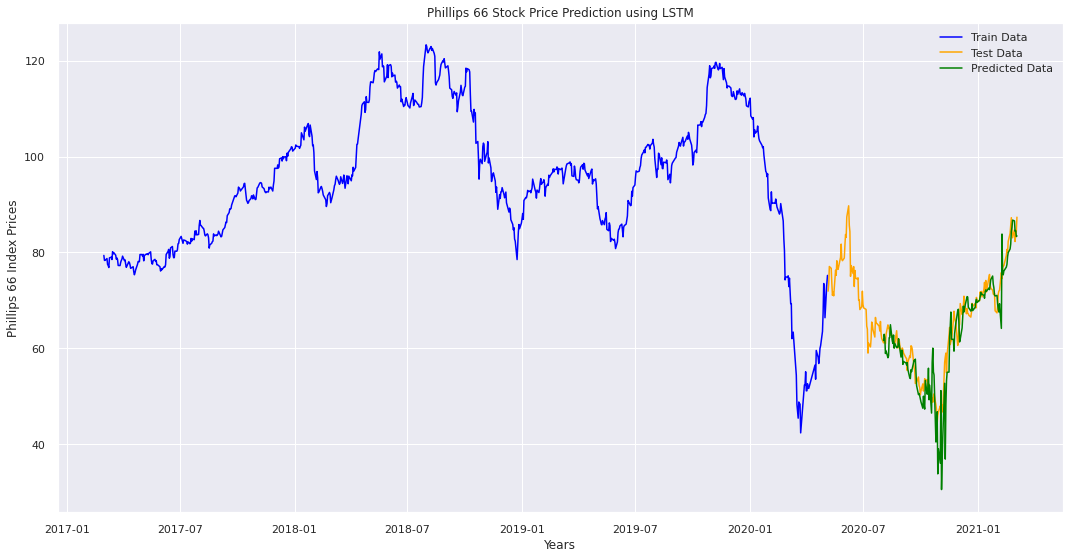

RMSE_LSTM = 63.78368480852033


In [326]:
plt.figure(figsize=(18, 9))
plt.plot(train_data['Date Value_gse'], train_data['Value_gse'], color = 'blue', label = 'Train Data')
plt.plot(test_data['Date Value_gse'], test_data['Value_gse'].values, color = 'orange', label = 'Test Data')
plt.plot(test_data.iloc[61:]['Date Value_gse'], predicted_stock_price, color = 'green', label = 'Predicted Data')
plt.title('Phillips 66 Stock Price Prediction using LSTM')
plt.xlabel('Years')
plt.ylabel('Phillips 66 Index Prices')
plt.legend()
plt.show()
from math import sqrt

RMSE_LSTM = sqrt(mean_squared_error(test_data.iloc[61:]['Polarity'].values, predicted_stock_price))

print(f"RMSE_LSTM = {RMSE_LSTM}")

#LSTM Model with all the independent variables

In [309]:
price = price.sort_values(by='Date Value_gse')

In [310]:
train_dates = pd.to_datetime(price['Date Value_gse'])
cols = list(price)[1:-1]
df_for_training = price[cols].astype(float)

In [311]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler = scaler.fit(df_for_training)
df_for_training_scaled = scaler.transform(df_for_training)

In [320]:
trainX = []
trainY = []
n_future = 240  # Number of days we want to predict into the future
n_past = 60     # Number of past days we want to use to predict the future

for i in range(n_past, len(df_for_training_scaled) - n_future +1):
    trainX.append(df_for_training_scaled[i - n_past:i, 0:df_for_training.shape[1]])
    trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future, 0])

trainX, trainY = np.array(trainX), np.array(trainY)

print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))


# define Autoencoder model

model = Sequential()
model.add(LSTM(64, activation='relu', kernel_initializer='lecun_normal',input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1], ))

model.compile(optimizer='adam',  loss='mse')
model.summary()


trainX shape == (749, 60, 12).
trainY shape == (749, 1).
Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_31 (LSTM)               (None, 60, 64)            19712     
_________________________________________________________________
lstm_32 (LSTM)               (None, 32)                12416     
_________________________________________________________________
dropout_15 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 33        
Total params: 32,161
Trainable params: 32,161
Non-trainable params: 0
_________________________________________________________________


In [321]:
# fit model
history = model.fit(trainX, trainY, epochs=20, batch_size=16, validation_split=0.1, verbose=1)

Epoch 1/20
43/43 [==============================] - 5s 64ms/step - loss: 11.4887 - val_loss: 0.3712
Epoch 2/20
43/43 [==============================] - 2s 53ms/step - loss: 0.3684 - val_loss: 0.6292
Epoch 3/20
43/43 [==============================] - 2s 53ms/step - loss: 0.2144 - val_loss: 0.9088
Epoch 4/20
43/43 [==============================] - 2s 52ms/step - loss: 0.1996 - val_loss: 3.7930
Epoch 5/20
43/43 [==============================] - 2s 53ms/step - loss: 0.1621 - val_loss: 0.8341
Epoch 6/20
43/43 [==============================] - 2s 52ms/step - loss: 0.1204 - val_loss: 1.3161
Epoch 7/20
43/43 [==============================] - 2s 52ms/step - loss: 0.1008 - val_loss: 1.0519
Epoch 8/20
43/43 [==============================] - 2s 52ms/step - loss: 0.0936 - val_loss: 1.3575
Epoch 9/20
43/43 [==============================] - 2s 54ms/step - loss: 0.0909 - val_loss: 1.7807
Epoch 10/20
43/43 [==============================] - 2s 56ms/step - loss: 0.0835 - val_loss: 1.8304
Epoch 11

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


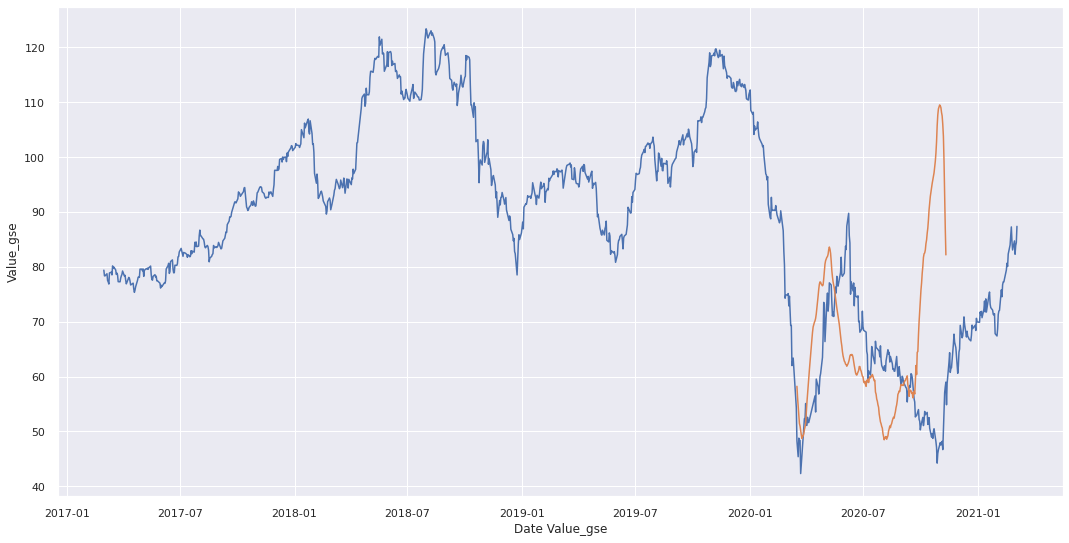

In [322]:
#Forecasting...
#Start with the last day in training date and predict future...
n_future=240  #Redefining n_future to extend prediction dates beyond original n_future dates...
tn_dates = train_dates
forecast_period_dates = pd.date_range(list(tn_dates)[len(df_for_training_scaled) - n_future +1], periods=n_future, freq='1d').tolist()

forecast = model.predict(trainX[-n_future:]) #forecast 

#Perform inverse transformation to rescale back to original range
#Since we used 5 variables for transform, the inverse expects same dimensions
#Therefore, let us copy our values 5 times and discard them after inverse transform
forecast_copies = np.repeat(forecast, df_for_training.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(forecast_copies)[:,0]


# Convert timestamp to date
forecast_dates = []
for time_i in forecast_period_dates:
    forecast_dates.append(time_i.date())
    
df_forecast = pd.DataFrame({'Date Value_gse':np.array(forecast_dates), 'Value_gse':y_pred_future})
df_forecast['Date Value_gse']=pd.to_datetime(df_forecast['Date Value_gse'])


original = price[['Date Value_gse', 'Value_gse']]
original['Date Value_gse']=pd.to_datetime(original['Date Value_gse'])
#original = original.loc[original['Date'] <= '2020-05-01']


sns.set(rc={'figure.figsize':(18,9)})
sns.lineplot(original['Date Value_gse'], original['Value_gse'])
sns.lineplot(df_forecast['Date Value_gse'], df_forecast['Value_gse'])


In [323]:
df_forecast

,Date Value_gse,Value_gse
0,2020-03-17,58.215271
1,2020-03-18,56.194908
2,2020-03-19,54.677757
3,2020-03-20,53.218586
4,2020-03-21,51.421356
...,...,...
235,2020-11-07,103.776405
236,2020-11-08,99.195648
237,2020-11-09,92.875778
238,2020-11-10,87.006569


In [348]:
df_forecast.to_csv('Forecast.csv')

In [344]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse = sqrt(mean_squared_error(original['Value_gse'][-240:], df_forecast['Value_gse']))
rmse

9.094617725302458

In [350]:
!git init

Initialized empty Git repository in /content/drive/MyDrive/Case_Competition/news_sent/.git/


In [358]:
!git config --global user.email nikhilgunti73@gmail.com
!git config --global user.name nikhilgunti

In [359]:
!git add img/ src/ results/ Data/
!git commit -m "Files necessary for reproduction"
!git remote add origin https://github.com/nikhilgunti/stock_pred_news.git
!git push -u origin master
!git push origin master

fatal: not a git repository (or any parent up to mount point /content)
Stopping at filesystem boundary (GIT_DISCOVERY_ACROSS_FILESYSTEM not set).
fatal: not a git repository (or any parent up to mount point /content)
Stopping at filesystem boundary (GIT_DISCOVERY_ACROSS_FILESYSTEM not set).
fatal: not a git repository (or any parent up to mount point /content)
Stopping at filesystem boundary (GIT_DISCOVERY_ACROSS_FILESYSTEM not set).
fatal: not a git repository (or any parent up to mount point /content)
Stopping at filesystem boundary (GIT_DISCOVERY_ACROSS_FILESYSTEM not set).
fatal: not a git repository (or any parent up to mount point /content)
Stopping at filesystem boundary (GIT_DISCOVERY_ACROSS_FILESYSTEM not set).


In [357]:
!git clone https://github.com/nikhilgunti/stock_pred_news.git

Cloning into 'stock_pred_news'...
remote: Enumerating objects: 7, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 7 (delta 0), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (7/7), done.
